In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Integration

In [2]:
from scipy import integrate

## Q1: integrating an analytic function

Numerical integration methods work differently depending on whether you have the analytic function available (in which case you can evaluate it freely at any point you please) or if it is sampled for you.

Consider the function $f(x) = e^{-x^2}$.  We want to integrate this from $[-5, 5]$.  The
analytic integral is not easily obtained.  Use `integrate.quad` to do the integration.

In [66]:
def f1(x):
    return np.exp(-x**2)
f1(5)
(Ia, Err) = integrate.quad(f1, -5,5) #analytic integral
print(Ia, Err)


1.7724538509027912 4.6261378229003154e-14


## Q2: integrating a sampled function

Consider now that you have data that represents a function sampled a `N` points, but you don't know the analytic form of the function.  Here, we create the sampling here for a Gaussian and we will do the same integral as in Q1.

In [19]:
N = 64
x = np.linspace(-5, 5, N, endpoint=True)
f = np.exp(-x**2)

Compute the integral of this sampled function using Simpson's method (`integrate.simps`).  Now, vary the number of sample points (try 64, 128, ...) and see how the answer changes.  Simpson's method is 4-th order accurate, which means that the error should decrease by $2^4$ when we double the number of sample points

In [68]:
grid = np.array([32,64,128,256])
Err = np.array([])
for N in grid:
    x = np.linspace(-5, 5, N, endpoint=True)
    f = np.exp(-x**2)
    In = integrate.simps(f, x) # Numerical integral
    print(In)
    Err = np.append(Err, (In-Ia)) 
Err    
       

1.7724538509168974
1.7724538509036147
1.772453850902865
1.7724538509027987


array([1.41062717e-11, 8.23563440e-13, 7.37188088e-14, 7.54951657e-15])

Optional: Make a plot of the error (compared to the analytic integral from Q1) vs. N

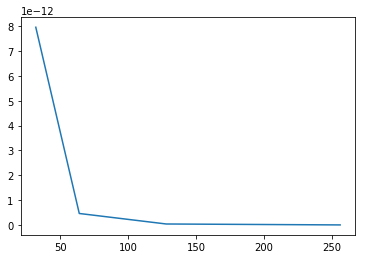

In [65]:
plt.plot(grid,Err)

# Interpolation

In [42]:
from scipy import interpolate

## Q3: interpolation error

There are a large number of different interpolation schemes available through scipy.  Let's test them out.

Create a python function, $f(x)$, that is your true function.  Now create $N$ samples of it (either regularly spaced or irregularly spaced).

Try some of the different interolation routines.  `interpolate.interp1d` takes a `kind` argument that let's you choose the order of the interpolation.  Measure the error in the method, by comparing the interpolated result with the actual function value.  Also, try using cubic splines (look at `CubicSpline`)

Try plotting the resulting interpolant.

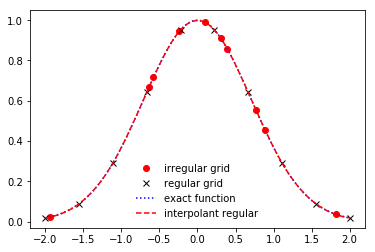

In [56]:
# We will use the previously defined f1 function (unnormalized gaussian)

N = 10
x1 = np.random.uniform(-2,2,N)
set1 = f1(x1)
x2 = np.linspace(-2, 2, N)
set2 = f1(x2)
N = 100
# use finer points when we plot
xgrid = np.linspace(-2, 2, N)
yexact = f1(xgrid)

set1_intpl = interpolate.interp1d(x1, set1, kind=3)
set2_intpl = interpolate.interp1d(x2, set2, kind=3)

plt.plot(x1, set1, "ro", label="irregular grid")
plt.plot(x2, set2, "kx", label="regular grid")
plt.plot(xgrid, yexact, "b:", label="exact function")
#plt.plot(xgrid, set1_intpl(xgrid), "r-", label="interpolant irregular")
plt.plot(xgrid, set2_intpl(xgrid), "r--", label="interpolant regular")

plt.legend(frameon=False, loc="best")



# Root Finding

## Q4: scalar function roots

Consider the function
$$q(x) = x^3 - 2x^2 - 11x + 12$$
This has 3 roots, but is known to cause problems for some root-finding methods (it exhibits basis of attraction: https://en.wikipedia.org/wiki/Newton%27s_method#Basins_of_attraction -- very closely spaced initial guesses leave to very different roots)

Use the SciPy `optimize.brentq` method to find the roots.  You might need to play around with the intervals to find all 3 roots (try plotting the function to help)

In [7]:
from scipy import optimize

Root convergence:  True True True
Roots:  -3.0 1.0 4.0


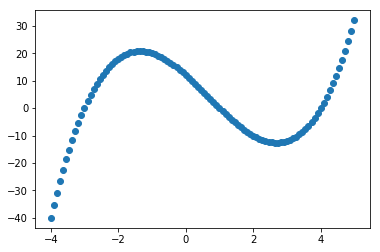

In [69]:
def func4(x):
    return x**3 - 2*x**2-11*x+12

plot4x = np.linspace(-4, 5, 100)
plot4y = func4(plot4x)

f4 = plt.figure()
ax4 = f4.add_subplot(111)
ax4.scatter(plot4x, plot4y)

root1, r1 = optimize.brentq(func4, -4, -2, full_output=True)
root2, r2 = optimize.brentq(func4, 1, 2, full_output=True)
root3, r3 = optimize.brentq(func4, 4, 5, full_output=True)

print('Root convergence: ', r1.converged, r2.converged, r3.converged)
print('Roots: ', root1, root2, root3)

# ODEs

## Q5: orbits

We want to consider planetary orbits.  To do this, we need to solve Newton's second law together with Newton's law of gravity.  If we restrict ourselves to the x-y plane, then there are 4 quantities we need to solve for: $x$, $y$, $v_x$, and $v_y$.  These evolve according to:
\begin{align*}
\frac{dx}{dt} &= v_x \\
\frac{dy}{dt} &= v_y \\
\frac{dv_x}{dt} &= a_x = -\frac{GM_\star x}{r^3} \\
\frac{dv_y}{dt} &= a_y = -\frac{GM_\star y}{r^3}
\end{align*}

To integrate these forward in time, we need an initial condition for each quantity.  We'll setup our system such that the Sun is at the origin (that will be one focus), and the planet begins at perihelion and orbits counterclockwise. 

![geometry](orbit_setup.png)

The distance of perihelion from the focus is:
$$r_p = a (1 - e)$$
where $a$ is the semi-major axis and $e$ is the eccentricity.  The perihelion velocity is all in the $y$ direction and is:
$$v_y = v_p = \sqrt{\frac{GM_\star}{a} \frac{1+e}{1-e}}$$

We'll work in units of AU, years, and solar masses, in which case, $GM_\star = 4\pi^2$ (for the Sun).  

Your initial conditions should be:
  * $x(t=0) = r_p$
  * $y(t=0) = 0$
  * $v_x(t=0) = 0$
  * $v_y(t=0) = v_p$

Here's a righthand side function for the ODEs:

In [70]:
def rhs(t, Y, GM=4*np.pi**2):
    """RHS for orbits, Y is the solution vector, containing
    x, y, v_x, and v_y"""

    x, y, vx, vy = Y
    f = np.zeros_like(Y)

    # dx/dt = vx
    f[0] = vx

    # dy/dt = vy
    f[1] = vy

    # d(vx)/dt = -GMx/r**3
    r = np.sqrt(x**2 + y**2)
    f[2] = -GM*x/r**3

    # d(vy)/dt = -GMy/r**3
    f[3] = -GM*y/r**3

    return f

Use the SciPy ODE integration methods to integrate an orbit and plot it

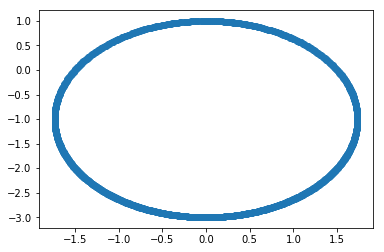

In [90]:
from scipy.integrate import odeint

a = 2 # semi mayor axis
e = 0.5 # eccentricity
rp = a*(1-e)
vp = np.sqrt((4*np.pi**2/a)*(1+e)/(1-e))
t = np.linspace(0, 20, 1000)
Y0 = [rp,0,0,vp]
sol = odeint(rhs,Y0,t)
plt.scatter(sol[0:,1],sol[0:,0])

## <span class="fa fa-star"></span> Q6: damped driven pendulum and chaos

There are a large class of ODE integration methods available through the `scipy.integrate.ode()` function.  Not all of them provide _dense output_ -- most will just give you the value at the end of the integration.  

The explicit Runge-Kutta integrator will give you access to the solution at intermediate points and provides methods to interpolate to any value.  You enable this via `dense_output=True` (see the example in our out-of-class notebook).

The damped driven pendulum obeys the following equations:
$$\dot{\theta} = \omega$$
$$\dot{\omega} = -q \omega - \sin \theta + b \cos \omega_d t$$
here, $\theta$ is the angle of the pendulum from vertical and $\omega$ is the angular velocity.  $q$ is a damping coefficient, $b$ is a forcing amplitude, and $\omega_d$ is a driving frequency.

Choose $q = 0.5$ and $\omega_d = 2/3$.

Integrate the system for different values of $b$ (start with $b = 0.9$ and increase by $0.05$, and plot the results ($\theta$ vs. $t$).  Here's a RHS function to get you started:

In [9]:
def rhs(t, Y, q, omega_d, b):
        """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
        f = np.zeros_like(Y)

        
        f[0] = Y[1]
        f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

        return f

Note that the pendulum can flip over, giving values of $\theta$ outside of $[-\pi, \pi]$.  The following function can be used to restrict it back to $[-\pi, \pi]$ for plotting.

In [10]:
def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

Write a function that takes an initial angle, $\theta_0$, and integrates the system and returns the solution.

Note, the righthand side function, `rhs`, takes additional arguments that you need to pass through the integrator.  The preferred method to do this with the `solve_ivp()` interface appears to be to use `functools.partial()`, as:
```
from functools import partial

r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b), ...)
```

Some values of $b$ will show very non-periodic behavior.  To see chaos, integrate two different pendula that are the same except for $\theta_0$, with only a small difference between then (like 60 degrees and 60.0001 degrees.  You'll see the solutions track for a while, but then diverge.

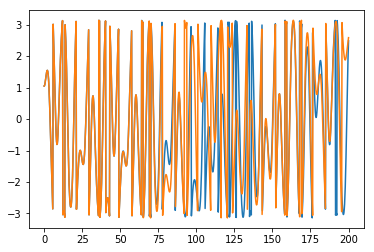

In [91]:
from scipy.integrate import ode
import numpy as np
import matplotlib.pyplot as plt

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew


def int_pendulum(theta0, q, omega_d, b, tend):
    r = ode(rhs)
    r.set_integrator("dopri5", nsteps=150000)

    sol = []
    r.set_solout(lambda t, y: sol.append([t, *y]))

    t0 = 0.0
    omega0 = 0.0
    r.set_initial_value((theta0, omega0), t0)

    r.set_f_params(q, omega_d, b)

    r.integrate(tend)
    return np.array(sol)


s = int_pendulum(np.radians(60), 0.5, 0.6666, 1.5, 200.0)
q = int_pendulum(np.radians(60.001), 0.5, 0.6666, 1.5, 200.0)

plt.plot(s[:,0], restrict_theta(s[:,1]))
plt.plot(q[:,0], restrict_theta(q[:,1]))

plt.show()
